# Simple Perceptron

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

In [2]:
input_path = '../../Data/'
training_images_filepath = join(input_path, 'MNIST/train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'MNIST/train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 'MNIST/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 'MNIST/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [3]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join
import random
import matplotlib.pyplot as plt
from copy import deepcopy


#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img/255
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self,load_train=True,augment=False,replace_set=True, num_of_copies=1, binary = False):
        if load_train:
            x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        else: x_train,y_train = ([],[])
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        if augment:
            if load_train:
                x_train, y_train = augment_data(x_train,y_train,replace_set,num_of_copies,binary=binary)
            x_test, y_test = augment_data(x_test, y_test,binary= binary, replace_set=True, num_of_copies=1)
        return (x_train, y_train),(x_test, y_test)


def image_shift(image,shift=None,shift_x = True,shift_y = True):
    image = np.asarray(image)
    if shift is None:
        if shift_x:
            x_shift = random.randint(-3,3)
        else:
            x_shift = 0
        if shift_y:
            y_shift = random.randint(-3,3)
        else:
            y_shift = 0
    else: x_shift,y_shift = shift
    if x_shift >= 0:
        # Remove columns from the left and pad with zeros on the right
        image = image[:, x_shift:]  # Remove columns from the left
        image = np.hstack((image, np.zeros((image.shape[0], x_shift))))  # Pad with zeros on the right
    else:
        # Remove columns from the right and pad with zeros on the left
        image = image[:, :image.shape[1] + x_shift]  # Remove columns from the right
        image = np.hstack((np.zeros((image.shape[0], abs(x_shift))), image))  # Pad with zeros on the left

    if y_shift >= 0:
        # Remove rows from the top and pad with zeros at the bottom
        image = image[y_shift:, :]  # Remove rows from the top
        image = np.vstack((image, np.zeros((y_shift, image.shape[1]))))  # Pad with zeros at the bottom
    else:
        # Remove rows from the bottom and pad with zeros at the top
        image = image[:image.shape[0] + y_shift, :]  # Remove rows from the bottom
        image = np.vstack((np.zeros((abs(y_shift), image.shape[1])), image))
    return image

def apply_noise(image,num_of_points=None):
    if num_of_points is None:
        num_of_points = random.randint(5,20)
    image = deepcopy(image)
    for _ in range(num_of_points):
        x,y = np.random.randint(0,28,2)
        noise = np.random.uniform(0,1)
        image[x][y] = np.clip(image[x][y]+noise,0.0,1.0)
    return image


def augment_data(x, y, replace_set=False, num_of_copies=9, binary = False):
    if replace_set or binary:
        x_new = []
        y_new = []
    else:
        x_new = deepcopy(x)
        y_new = deepcopy(y)
    for i,image in enumerate(x):
        if binary:
            if y[i] in [0,1]:
                y_new.append(y[i])
                x_new.append(image)
        else:
            for _ in range(num_of_copies):
                shifted_image = image_shift(image)
                # shifted_image = apply_noise(shifted_image)
                x_new.append(shifted_image)
                y_new.append(y[i])
    return x_new,y_new


mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data(augment=True, binary = True)

In [4]:
x_train = np.asarray(x_train).reshape(-1,784)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test).reshape(-1,784)
y_test = np.asarray(y_test)

In [5]:
for i in range(len(y_train)):
    if y_train[i] == 0:
        y_train[i] = -1

for i in range(len(y_test)):
    if y_test[i] == 0:     
        y_test[i] = -1


In [6]:
y_train.shape

(12665,)

In [7]:
x_test.shape

(2115, 784)

In [8]:
class SimplePerceptron:
    def __init__(self, dim):
        self.dim = dim
        self.W = np.random.uniform(-1,1, (1,self.dim))
        self.B = np.random.uniform(-1,1)

    def forward(self, X):
        return np.sign(np.dot(X,self.W.T) + self.B)

    def backward(self, X, y_true, y_pred, learning_rate = 0.001):
        misclassified_idx = np.where(y_pred != y_true)[0]

        x_misclassified = X[misclassified_idx]
        y_misclassified = y_true[misclassified_idx]

        self.W += learning_rate * np.dot(y_misclassified, x_misclassified) 
        self.B += learning_rate * np.sum(y_misclassified)

In [9]:
perceptron = SimplePerceptron(784)

epochs = 90
lr = 0.001
num_batches = 10
batch_size_train = len(x_train)//num_batches
batch_size_test = len(x_test)//num_batches

accuracies = []

for epoch in range(epochs):

    if (epoch + 1)%(epochs//5) == 0:
        print(f"{100*(epoch + 1)//(epochs)}% completed.")
    accuracy = 0
    for i in range(num_batches):
        min_index = i*batch_size_test
        max_index = (i+1)*batch_size_test
        if (i+2)*batch_size_test > len(x_test):
            max_index = len(x_test)

        x_batch, y_batch = x_test[min_index:max_index], y_test[min_index:max_index]
        
        y_pred = perceptron.forward(x_batch)
        accuracy += np.sum(y_pred[:,0] == y_batch)
        
    accuracies.append(round(100*accuracy/len(x_test),2))
    
    for i in range(num_batches):
        min_index = i*batch_size_train
        max_index = (i+1)*batch_size_train
        if (i+2)*batch_size_train > len(x_train):
            max_index = len(x_train)
        
        x_batch, y_batch = x_test[min_index:max_index], y_test[min_index:max_index]
        
        y_pred = perceptron.forward(x_batch)[:,0]

        perceptron.backward(x_batch, y_batch, y_pred, lr)
    

20% completed.
40% completed.
60% completed.
80% completed.
100% completed.


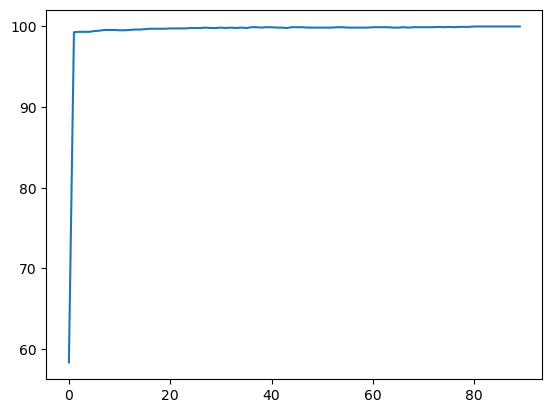

In [10]:
plt.plot(accuracies)

In [11]:
accuracy = 0
for i in range(len(x_test)):
    y_pred = perceptron.forward(x_test[i])
    
    if (y_pred[0] == y_test[i]):
        accuracy += 1
    else:
        print("Incorrectly identified sample",i)

print(f"Accuracy : {round(100*accuracy/len(x_test),2)}%")

Accuracy : 100.0%


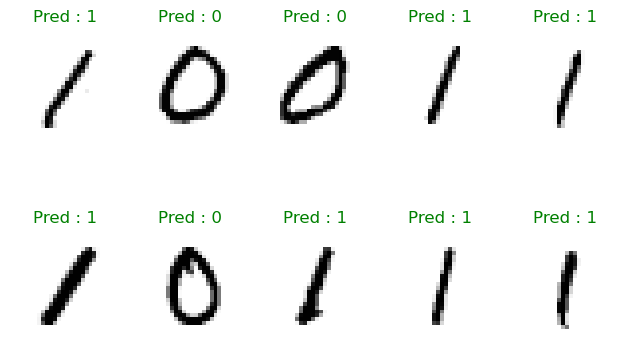

In [17]:
sample_indices = np.random.choice(list(range(len(x_test))),10,replace=False)
fig,axs = plt.subplots(2,5)
for i in range(2):
    for j in range(5):
        sample_idx = sample_indices[5*i+j]
        y_pred = perceptron.forward(x_test[sample_idx])
        axs[i,j].imshow(x_test[sample_idx].reshape(28,28),cmap='Greys')
        axs[i,j].axis('off')
        axs[i,j].set_title(f'Pred : {max(0,int(y_pred[0]))}',color='green' if y_test[sample_idx] == y_pred[0] else 'red')

plt.tight_layout()
plt.show()